In [1]:
%matplotlib inline
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

AMS 241, Problem Set 1, Problem 2

Zachary Jennings

Consider a DP prior $DP(\alpha,G_0)$ with $G_0 = N(0,1)$. 

In [143]:
#Data generation for problem 3
def gen_single(n):
    return stats.norm.rvs(size=n)

def gen_mixture(n):
    #generate the proportions of mixtures
    gen_select = stats.uniform.rvs(size=n)
    mix_1 = np.sum(gen_select < 0.5)
    mix_2 = np.sum((gen_select < 0.8) & (gen_select > 0.5))
    mix_3 = np.sum(gen_select > 0.8)
    
    #generate the actual distributions
    data = np.array([])
    data = np.append(data,stats.norm.rvs(loc=-2.5,scale=0.5,size=mix_1))
    data= np.append(data,stats.norm.rvs(loc=0.5,scale=0.7,size=mix_2))
    data = np.append(data,stats.norm.rvs(loc=1.5,scale=2,size=mix_3))
    return data


In [278]:
class DP(object):
    '''
    Class to hold a DP prior.
    '''
    def __init__(self,g='foo',func_type='normal',**kwargs):
        '''
        Parameters:
        g: scipy.stats object. if not specified, function type is used
        alpha: precision parameter for dirichlet distribution
        '''            
        #check if custom function is passed, else use that specified
        if g == 'foo':
            if func_type == 'normal':
                self.g = stats.norm(**kwargs)
            elif func_type == 'uniform':
                self.g = stats.uniform(**kwargs)
            else:
                print 'Error: No valid function supplied or specified.'
                
        else:
            self.g = g
        
        
    def draw_cdf_ferg(self,alpha=1.,grid=np.linspace(-6,6,1000),n_cdf=1,g_0=None):
        '''
        Draw a CDF realization, using method of Fergueson 1973
        Parameters:
            grid: n x 1 space of values on which to draw Dirichlet values
            
            n_cdf: int
                number of CDFs to generate
                
            g_0: if supplied, function g_0 to draw x values from
        
        '''
        if g_0 is None:
            g_0 = self.g
    
        g_draws = g_0.cdf(grid)
        g_draws = np.insert(g_draws,grid.size,1.)
        g_diff = g_draws[1:] - g_draws[:-1]
        
        cdf_arr = []
        for i in range(n_cdf):
            p = stats.dirichlet.rvs(alpha*g_diff)
            p = np.insert(p,0.,0.)
            p = np.cumsum(p)
            cdf_arr.append(CDF(grid,p))
        
        return cdf_arr
    
    def draw_cdf_stick(self,alpha=1.,n_cdf=1,e=0.001,n_max=1e4,g_0=None):
        '''
        Draw a CDF realization, using stick-breaking constructive method.
        Stop occurs using error-tolerance stop.
        '''
        if g_0 is None:
            g_0 = self.g
        #generate lists to hold the relevant values
        cdf_arr = []
        beta = stats.beta(1,alpha)
        
        #start the primary cdf generation loop
        for i in range(n_cdf):
            x = []
            p = []
            z = []
            z.append(beta.rvs())
            x.append(g_0.rvs())
            p.append(z[0])
            
            #iterate for stick breaking process with appropriate exit conditions
            stop_point = (alpha/(1.+alpha))**len(x)
            while stop_point > e and len(x) < n_max:
                x.append(g_0.rvs())
                this_z = beta.rvs()
                this_w = np.prod(1.-np.array(z))
                p.append(this_w * this_z)
                
                z.append(this_z)
    
                if len(x) >= n_max:
                    print 'Max iterations exceeded, exiting generation loop'

                
            self.x = x
            self.z = z
            self.p = p
                
            sort_x = np.argsort(x)
            x = np.array(x)[sort_x]
            p = np.insert(p,0.,0.)
            p = np.cumsum(np.array(p)[sort_x])
            cdf_arr.append(CDF(x,p))
            
            
        return cdf_arr
    
    def mdp_gamma(self,grid=np.linspace(-4,4,100),a=1.,b=1.,n_cdf=1):
        gamma = stats.gamma(a,b)
        cdf_arr = []

        for i in np.arange(n_cdf):
            alpha = gamma.rvs()
            draw_cdf = self.draw_cdf_ferg(alpha=alpha,n_cdf=1,grid=grid)[0]
            cdf_arr.append(draw_cdf)
        
        return cdf_arr
    
    def plot_cdfs(self,cdf_arr,ax=None,grid=np.linspace(-4,4,200),**kwargs):
        '''
        Plot a list of CDFs for values of grid
        Parameters:
            cdf_arr: list of CDF objects
            grid: x-grid for plotting
        '''
        if ax is None:
            fig,ax = plt.subplots()
        ax.set_ylim(0.,1.)
        
        for i in cdf_arr:
            p = map(i.get_prob,grid)
            ax.plot(grid,p,**kwargs)
            
    def post_inf(self,emp,g_0,alpha=1.,n_cdf=1,**kwargs):
        '''
        Return draw of posterior distribution

        Parameters:
            emp: CDF object containing emperical cdf of data
            g_0 scipy.stats object
        '''
        mix = MixFunction(emp,g_0,alpha)
        alpha_prime = emp.x.size + alpha
        draws = self.draw_cdf_ferg(alpha=alpha_prime,n_cdf=n_cdf,g_0=mix,**kwargs)
        return draws
    
            
class MixFunction(object):
    '''
    Class to hold two emperical CDFs.
    
    Parameters:
        emp: emperical CDF
        g_0: "prior" distribution, scipy.stats.continuous_rv
        
    Methods:
        RV: draw n random variables
        CDF: return the CDF at a given X of the mixture distribution
    '''
    def __init__(self,emp,g_0,alpha):
        self.emp = emp
        self.g_0 = g_0
        self.alpha = alpha
        
    def rvs(self,size=1):
        emp_weight = self.emp.x.size / (self.alpha+self.emp.x.size)
        mixture = stats.uniform.rvs(size=size)
        if np.sum(mixture < emp_weight) > 0:
            emp_draws = self.emp.rvs(size=np.sum(mixture < emp_weight))
        else:
            emp_draws = []
        if np.sum(mixture > emp_weight) > 0:
            prior_draws = self.g_0.rvs(size=np.sum(mixture > emp_weight))
        else:
            prior_draws = []
        return np.concatenate([emp_draws,prior_draws])

    def cdf(self,check_x):
        cdf_emp = np.array(map(self.emp.get_prob,check_x))
        cdf_prior = self.g_0.cdf(check_x)

        emp_weight = self.emp.x.size / (self.alpha+self.emp.x.size)
        prior_weight = 1.-emp_weight
        
        return cdf_emp * emp_weight + cdf_prior * prior_weight

    
class CDF(object):
    '''
    Class to hold a single 1D discrete, DP-generated CDF
    '''
    def __init__(self,x,p):
        '''
        Parameters:
        x: n x 1 array where 
        p: (n+1) x 1 array which holds P(X < x)
        '''
        self.x = np.array(x)
        self.cdf = np.array(p)
        #ins_cdf = np.insert(self.cdf,0,0.)
        self.pdf = self.cdf[1:] - self.cdf[:-1]
        
    def get_prob(self,check_x):
        '''
        Return P(x < check_x)
        '''
        #if check_x is below the region where the CDF is defined, make sure to return 0.     
        if np.all(check_x < self.x):
            return 0.0
                
        if np.all(check_x > self.x):
            return 1.0
        
        diff = check_x - self.x
        mask = diff < 0.
        
        masked_diff = np.ma.masked_array(diff, mask)
        return self.cdf[masked_diff.argmin()+1]
    
    def rvs(self,size=1):
        '''
        Parameters:
            size: int, number of rvs desired
            
        Returns:
            RVs drawn from cumulative distribution
        '''
        probs = np.array(stats.uniform.rvs(size=size))
        rvs = []
        for i in probs:
            rvs.append(self.x[np.argmin(np.abs(self.cdf[:-1] - i))])
            
        return rvs
    
    def get_mean(self):
        '''
        Return the mean (weighted average) of the distributuion
        '''
        return np.sum(self.pdf * self.x)
    
    def get_sd(self):
        '''|
        Return the weighted variance of the distribution
        '''
        return np.sum(self.pdf * self.x**2) - self.GetMean()**2
        
        #return np.sum(self.pdf * (self.x - self.GetMean())**2)/((self.pdf.size - 1.)/(self.pdf.size)*np.sum(self.pdf))


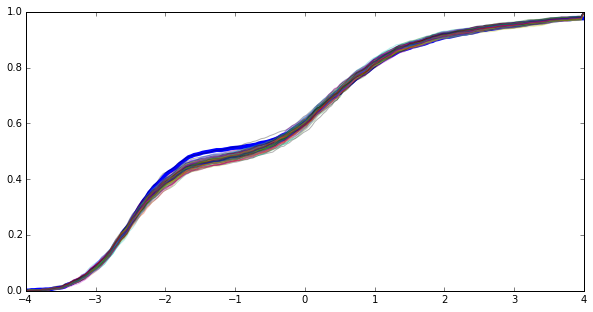

In [295]:
dat = gen_mixture(2000)
emp_cdf = CDF(np.sort(dat),np.linspace(0,1,dat.size+1))
g_0 = stats.norm()
dp = DP()
grid = np.linspace(-4,4,200)
post = dp.post_inf(emp_cdf,g_0,alpha=200.,n_cdf=100,grid=grid)
emp_cdf = [emp_cdf]
fig,ax = plt.subplots(figsize=(10,5))
dp.plot_cdfs(emp_cdf,linewidth=4,ax=ax,c='b',grid=grid)
dp.plot_cdfs(post,alpha=0.3,ax=ax,grid=grid)


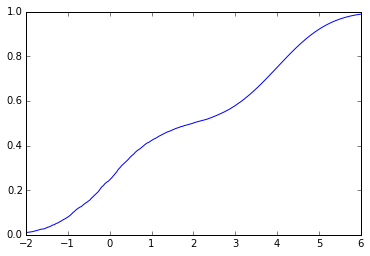

In [191]:
mix = MixFunction(emp_cdf,stats.norm(loc=4.),2000.)
grid = np.linspace(-2,6,200)
plt.plot(grid,mix.cdf(grid))
#foo = mix.cdf(np.linspace(-4,6,200))

array([  2.48838423e-16,   3.73780338e-16,   5.60060164e-16,
         8.37090314e-16,   1.24804298e-15,   1.85612216e-15,
         2.75361708e-15,   4.07493533e-15,   6.01531366e-15,
         8.85760736e-15,   1.30105415e-14,   1.90631793e-14,
         2.78622717e-14,   4.06218004e-14,   5.90776880e-14,
         8.57057031e-14,   1.24027530e-13,   1.79039497e-13,
         2.57811464e-13,   3.70321111e-13,   5.30612942e-13,
         7.58403946e-13,   1.08130191e-12,   1.53786163e-12,
         2.18178388e-12,   3.08766838e-12,   4.35887392e-12,
         6.13822761e-12,   8.62257508e-12,   1.20824942e-11,
         1.68889297e-11,   2.35490770e-11,   3.27545924e-11,
         4.54461795e-11,   6.28998718e-11,   8.68419724e-11,
         1.19601735e-10,   1.64313600e-10,   2.25184312e-10,
         3.07844718e-10,   4.19811768e-10,   5.71093504e-10,
         7.74978992e-10,   1.04906678e-09,   1.41660000e-09,
         1.90819458e-09,   2.56406963e-09,   3.43691778e-09,
         4.59558799e-09,

In [6]:
dp = DP()
cdf_arr = dp.MDPGamma(n_cdf=30,a=1,b=1)
means = []
stddevs = []
for i in cdf_arr:
    means.append(i.GetMean())
    stddevs.append(i.GetSD())
print np.median(means)

0.174725262234


In [21]:
foo = stats.rv_discrete(name='emperical_cdf',values=(cdf_arr[0].x,cdf_arr[0].pdf))
xk = np.arange(7)
pk = (0.1, 0.2, 0.3, 0.1, 0.1, 0.0, 0.2)
custm = stats.rv_discrete(name='custm', values=(xk, pk))
foo.rvs(size=10)

array([ 1,  0, -1,  0,  0, -1, -1,  0,  0,  0])

In [30]:
foo = np.linspace(0,1,101)
x = np.arange(100)
probs = stats.uniform.rvs(size=10)
rvs = []
for i in probs:
    rvs.append(x[np.argmin(np.abs(foo - i))])


In [31]:
print rvs
print probs
print foo
print x

[77, 57, 53, 50, 92, 79, 7, 12, 44, 41]
[ 0.76574719  0.56901751  0.52766814  0.50275942  0.92490194  0.78949967
  0.07316107  0.12465406  0.44441273  0.40666432]
[ 0.    0.01  0.02  0.03  0.04  0.05  0.06  0.07  0.08  0.09  0.1   0.11
  0.12  0.13  0.14  0.15  0.16  0.17  0.18  0.19  0.2   0.21  0.22  0.23
  0.24  0.25  0.26  0.27  0.28  0.29  0.3   0.31  0.32  0.33  0.34  0.35
  0.36  0.37  0.38  0.39  0.4   0.41  0.42  0.43  0.44  0.45  0.46  0.47
  0.48  0.49  0.5   0.51  0.52  0.53  0.54  0.55  0.56  0.57  0.58  0.59
  0.6   0.61  0.62  0.63  0.64  0.65  0.66  0.67  0.68  0.69  0.7   0.71
  0.72  0.73  0.74  0.75  0.76  0.77  0.78  0.79  0.8   0.81  0.82  0.83
  0.84  0.85  0.86  0.87  0.88  0.89  0.9   0.91  0.92  0.93  0.94  0.95
  0.96  0.97  0.98  0.99  1.  ]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72

In [353]:
cdf_arr = []
grid = np.linspace(-4,4,100)
med_arr = []
stddev_arr = []
for j in range(50):
    means = []
    stddev = []
    cdf_arr = []
    
    for i in range(1000):
        x = stats.norm.rvs(size=100)
        x = np.sort(x)
        y = np.linspace(0.,1.,101)
        cdf_arr.append(CDF(x,y))
        means.append(cdf_arr[i].GetMean())
        stddev.append(cdf_arr[i].GetSD())
        
    med_arr.append(np.median(means))
    stddev_arr.append(np.median(stddev))


In [83]:
foo = np.insert(cdf_arr[0].cdf,cdf_arr[0].cdf.size,1.)
print foo[1:] - foo[:-1]
print cdf_arr[0].cdf[:] - np.insert(cdf_arr[0].cdf,cdf_arr[0].cdf.size,1.)[:-1]

[  3.25578215e-18   2.82835379e-24   4.20527855e-07   4.88049796e-19
   6.46182301e-12   2.14117372e-07   8.94515352e-06   2.54985947e-04
   3.05321663e-04   5.59104615e-10   2.16793406e-05   4.60126088e-04
   5.73005726e-04   9.42933946e-05   3.28489555e-04   1.35049258e-04
   1.34988171e-03   3.00147177e-03   2.27591395e-03   1.30576421e-03
   3.38103647e-03   1.03868344e-03   2.68944825e-03   6.54741632e-03
   1.05916909e-02   2.76308748e-03   3.68274942e-03   6.57318133e-03
   1.01000596e-02   1.36014984e-02   4.52641529e-03   1.46116745e-02
   1.68564196e-02   9.20372427e-03   1.86540853e-02   1.61757737e-02
   1.82539802e-02   2.35110357e-02   2.76798819e-02   2.52390408e-02
   2.23895349e-02   2.28074022e-02   3.72845177e-02   3.00035850e-02
   3.21814549e-02   2.48242458e-02   3.43607473e-02   2.51439391e-02
   3.36968759e-02   3.47058469e-02   3.80207036e-02   2.75784732e-02
   2.91625307e-02   2.37799528e-02   2.35281060e-02   2.92920591e-02
   2.01382774e-02   3.15985896e-02

In [98]:
foo = np.array(stats.uniform.rvs(size=5))
for i in foo:
    print i

0.445411343028
0.468204203044
0.023580938754
0.0444806498827
0.195169020849


In [52]:
grid = np.linspace(-4,4,100)
g_draws = stats.norm.cdf(grid)
g_draws = np.insert(g_draws,grid.size,1.)
g_diff = g_draws[1:] - g_draws[:-1]
print g_diff.size

100


In [238]:
class EmpericalDistribution(stats.rv_continuous):
    
    def SetParameters(self,x,p,d_type='cdf'):
        p = np.array(p)[np.argsort(x)]
        self.x = np.array(x)[np.argsort(x)]
        
        if d_type == 'pdf':
            self.p = np.cumsum(p)
        else:
            self.p = p
        
        
    
    def _cdf(self,check_x):
        if np.all(check_x < self.x):
            return 0.0
        
        if np.all(check_x > self.x):
            return 1.0
        
        diff = check_x - self.x
        mask = diff < 0.
        
        masked_diff = np.ma.masked_array(diff, mask)
        return self.p[masked_diff.argmin()]

In [109]:
dp.p

[0.2183850826968432,
 0.78131196631067978,
 0.19299689233354664,
 0.010697301704192152,
 0.0037585826834016633,
 0.0094372690352094359,
 0.001789514262302305,
 6.777355704258306e-06,
 4.3939264958602757e-07,
 8.9026124561464268e-07]

In [171]:
cdf = CDF(np.array([0,1,2,3]),np.array([0.1,0.3,0.95,1.0]))

In [154]:
diff = -0.5 - np.array([0,1,2,3])
print diff
mask = diff < 0
print mask
masked_diff = np.ma.masked_array(diff,mask)
print masked_diff
print masked_diff.argmin()

[-0.5 -1.5 -2.5 -3.5]
[ True  True  True  True]
[-- -- -- --]
0


In [64]:
g_grid = rv.cdf(foo)
g_diff = g_grid[1:] - g_grid[:-1]
p = stats.dirichlet.rvs(g_diff * 0.1)

In [32]:
len(cdf_arr[0].x)
(10./(10.+1))**10000

0.0

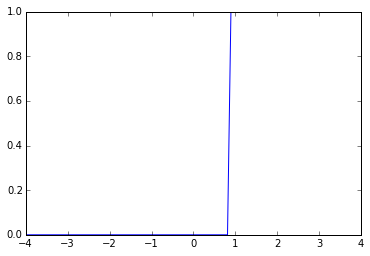

In [67]:
plt.plot(np.linspace(-4,4,99),sum)

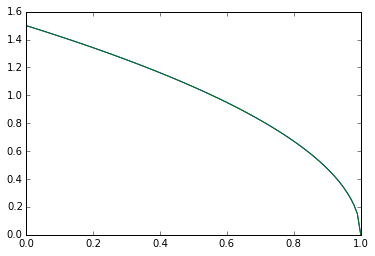

In [81]:
a = 1
b = 1.5
foo = np.linspace(0,1,100)
beta = stats.beta(a,b)
plt.plot(foo,beta.pdf(foo))
plt.plot(foo,stats.beta.pdf(foo,a,b))